
    0: bite
    1: chew
    2: chew-bite


In [1]:
# Beat tracking example
from __future__ import print_function
import librosa
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.fftpack import fft
import pandas as pd
import numpy as np
import os
import time
from scipy.io import wavfile as wv
from scipy import signal
import pywt

In [2]:
import seaborn as sns

#### Functions

In [3]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

In [4]:
def lowpass(signal, sample_freq, cutoff_freq):
    # Low-pass filtering 
    norm_cutoff_freq = cutoff_freq / (sample_freq / 2.0)
    b, a = signal.butter(2, norm_cutoff_freq, 'low')
    return signal.filtfilt(b, a, y, axis=0)

In [5]:
class WaveDataset():
    def __init__(self, data_folder, annotation_file):
        self.data_folder = data_folder
        ds = pd.read_csv(annotation_file)
        self.filenames = list(ds['filename'])
        if 'label' in ds.columns:
            self.labels = list(ds['label'])
        else:
            self.labels = [-1 for i in range(len(self.filenames))]
        self.cache = {}
        
    def __len__(self):
        return(len(self.labels))

    def __getitem__(self, index):
        if index in self.cache:
            data, label = self.cache[index]
        else:
            fname = os.path.join(self.data_folder, "%04d.wav" % self.filenames[index])
            _, data = wv.read(fname)
            label = self.labels[index]
            self.cache[index] = (data, label)
        return data, label

In [6]:
def discrete_wavelet(raw_signal, waveletname = 'sym5', levels = 5):
    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title("Original Signal: ")
    ax.plot(raw_signal)
    plt.show()


    fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(6,6))
    for ii in range(levels):
        (data, coeff_d) = pywt.dwt(raw_signal, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')
        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        axarr[ii, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()
    pass

In [7]:
def plot_wavelet(time, signal, scales, waveletname = 'cmor'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    # Show w.r.t. time and frequency
    plt.figure(figsize=(5, 2))
    plt.pcolor(time, frequencies, coefficients)

    # Set yscale, ylim and labels
    plt.yscale('log')
    plt.ylim([1, 100])
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    #plt.savefig('egg.png', dpi=150)
    
    pass

### Load data

In [8]:
train_labels = pd.read_csv('data/raw/train_labels.csv')

#### Categorias

In [9]:
category_group = train_labels.groupby('label').size().reset_index()
category_group.columns = ['label','counts']

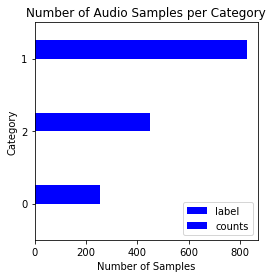

In [10]:
plot = category_group.sort_values(ascending=True, by='counts').plot(
    kind='barh', 
    title="Number of Audio Samples per Category", 
    color='blue', 
    figsize=(4,4))
plot.set_xlabel("Number of Samples")
plot.set_ylabel("Category");

In [11]:
category_group 

,label,counts
0,0,255
1,1,827
2,2,450


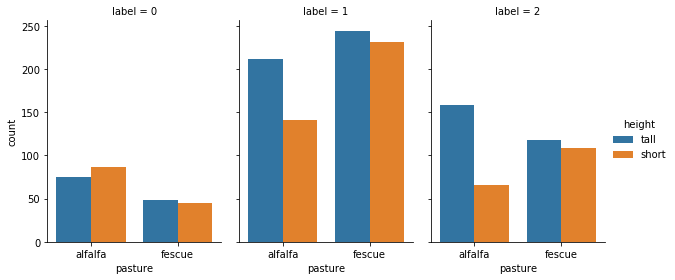

In [12]:
g = sns.catplot(x="pasture", hue="height", col="label",
                data=train_labels, kind="count",
                    height=4, aspect=.7);
#plt.title("Number of Audio Samples by Category and Pastures ");

## chew-bite

#### raw signal

In [13]:
filename = 'data/raw/0004.wav'

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(filename)

In [20]:
len(y)/sr

0.8

In [14]:
ipd.Audio(filename) # load a local WAV file

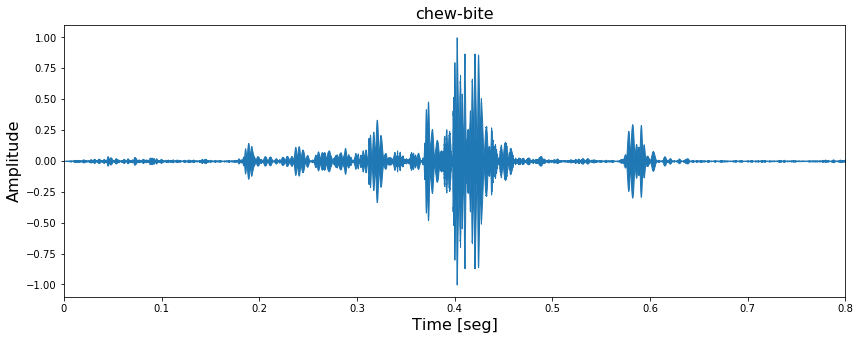

In [15]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)
plt.title('chew-bite',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Time [seg]', fontsize=16)
pass

#### Fourier

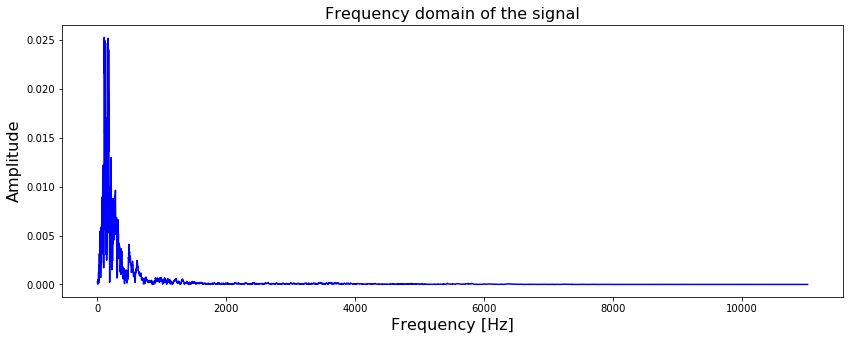

In [16]:
N = len(y)
T = 1/sr

f_values, fft_values = get_fft_values(y, T, N, sr)
plt.figure(figsize=(14, 5))

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

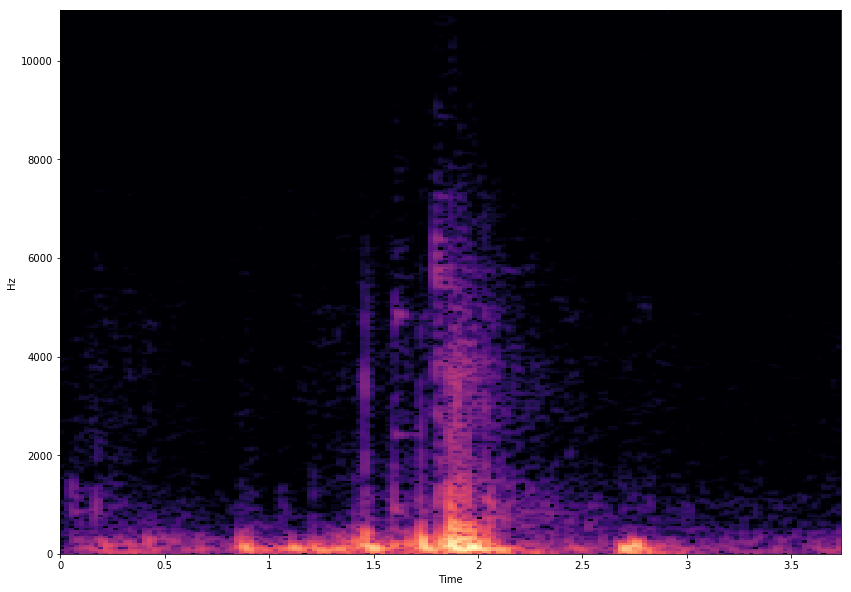

In [21]:
Y = librosa.stft(y,  n_fft=512, win_length=441,hop_length=110)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

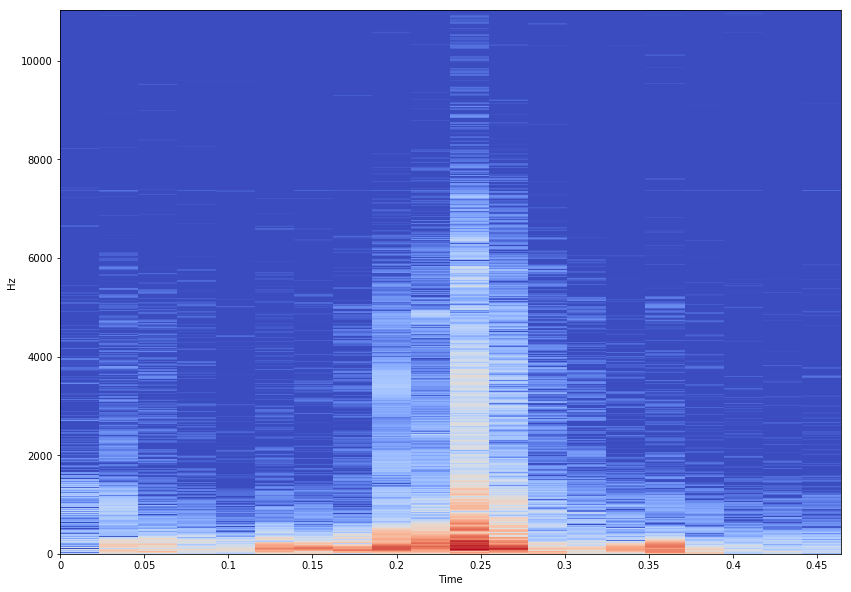

In [23]:
Y = librosa.stft(y,  n_fft=1323, win_length=1323,hop_length=882)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

#### MFCC

In [16]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
# also N of FFT is defined with this value
hop_length = 512

In [17]:
# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, dct_type=2, n_mfcc=40)

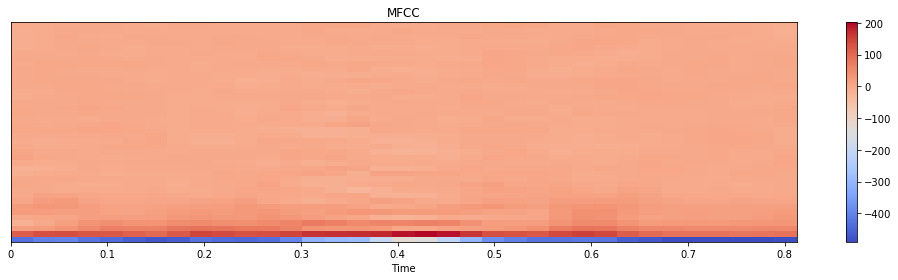

In [18]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Wavelet

#### Discrete wavelet

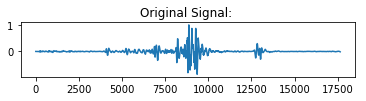

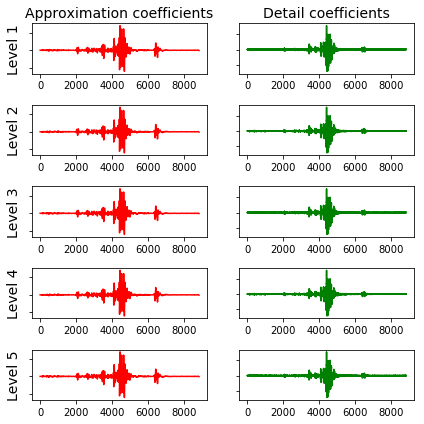

In [20]:
discrete_wavelet(y, waveletname='haar',levels=5)

In [49]:
N = len(y)
T = 1/sr
time = np.arange(0, N) * T

scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'

#fig, ax = plt.subplots(figsize=(10, 10))
plot_wavelet(time, y, scales)
#plt.show()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcafb95ed08> (for post_execute):


TypeError: Cannot cast array data from dtype('complex128') to dtype('int64') according to the rule 'safe'

Error in callback <function flush_figures at 0x7fcafb8ea6a8> (for post_execute):


KeyboardInterrupt: 

In [58]:
# Define signal
N = len(y)
T = 1/sr
time = np.arange(0, N) * T

# Calculate continuous wavelet transform
coef, freqs = pywt.cwt(y, np.arange(1, 50), 'mexh',
                       sampling_period=T)



Text(0.5, 0, 'Time (sec)')

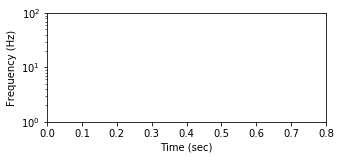

In [59]:
# Show w.r.t. time and frequency
plt.figure(figsize=(5, 2))
plt.pcolor(time, freqs, coef)

# Set yscale, ylim and labels
plt.yscale('log')
plt.ylim([1, 100])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
#plt.savefig('egg.png', dpi=150)

## chew

#### raw signal

In [20]:
filename = 'data/raw/0010.wav'

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(filename)

In [21]:
ipd.Audio(filename) # load a local WAV file

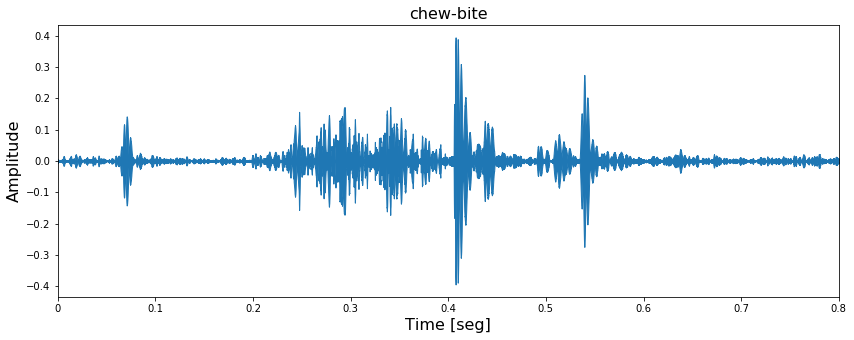

In [22]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)
plt.title('chew-bite',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Time [seg]', fontsize=16)
pass

#### Fourier

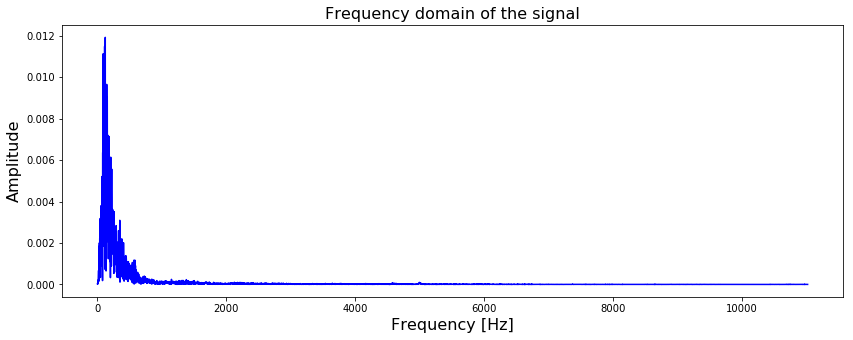

In [23]:
N = len(y)
T = 1/sr

f_values, fft_values = get_fft_values(y, T, N, sr)
plt.figure(figsize=(14, 5))

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

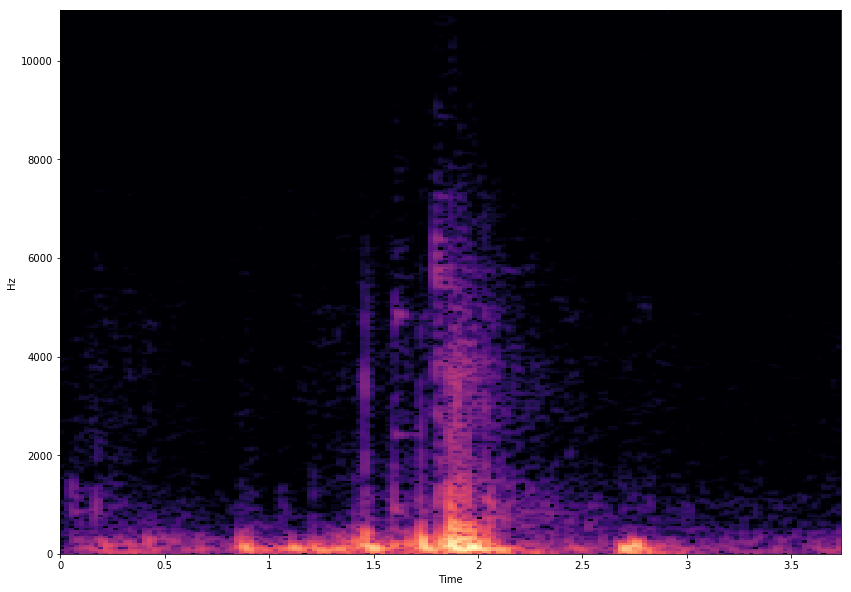

In [27]:
Y = librosa.stft(y,  n_fft=512, win_length=441,hop_length=110)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

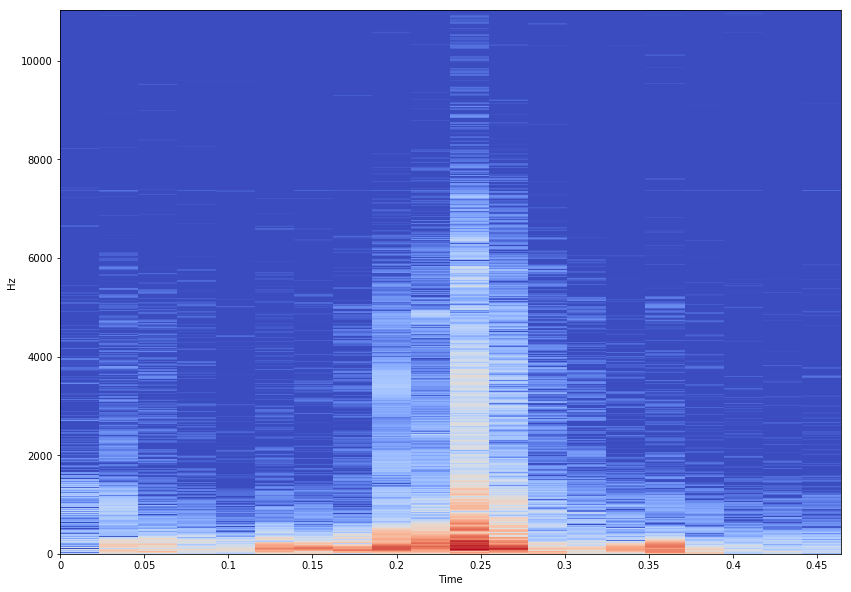

In [25]:
Y = librosa.stft(y,  n_fft=1323, win_length=1323,hop_length=882)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

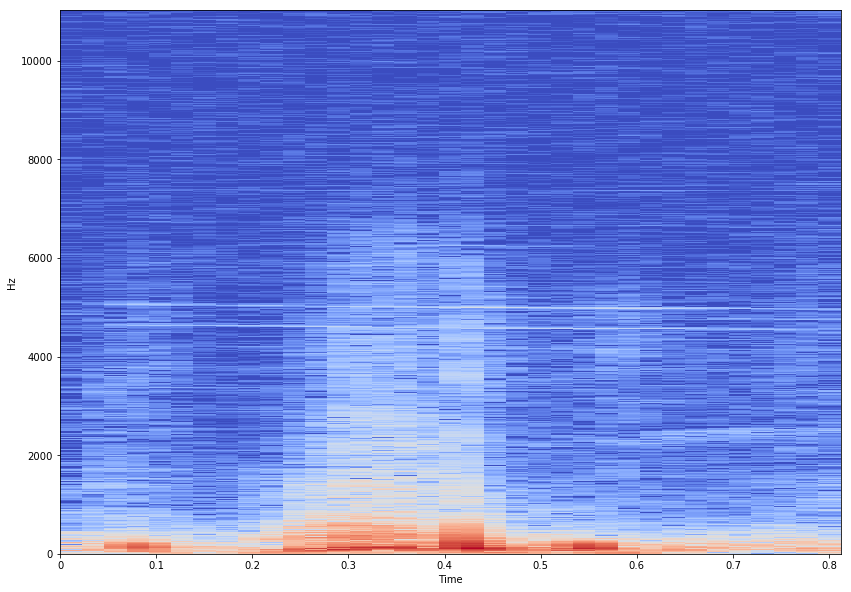

In [24]:
Y = librosa.stft(y) #,  n_fft=512, win_length=512,hop_length=220)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

#### MFCC

In [25]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
# also N of FFT is defined with this value
hop_length = 512

In [26]:
# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, dct_type=2, n_mfcc=14)

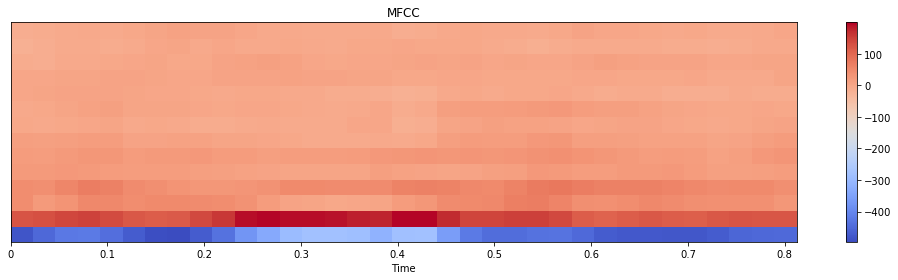

In [27]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Wavelet

#### Discrete wavelet

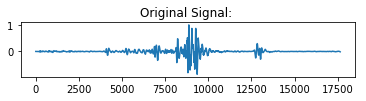

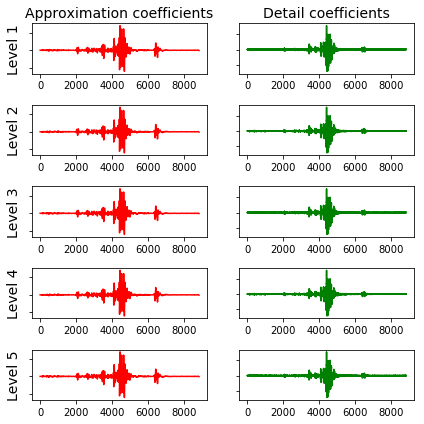

In [32]:
discrete_wavelet(y, waveletname='haar', levels=5)

## bite

#### raw signal

In [29]:
filename = 'data/raw/0049.wav'

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(filename)

In [30]:
ipd.Audio(filename) # load a local WAV file

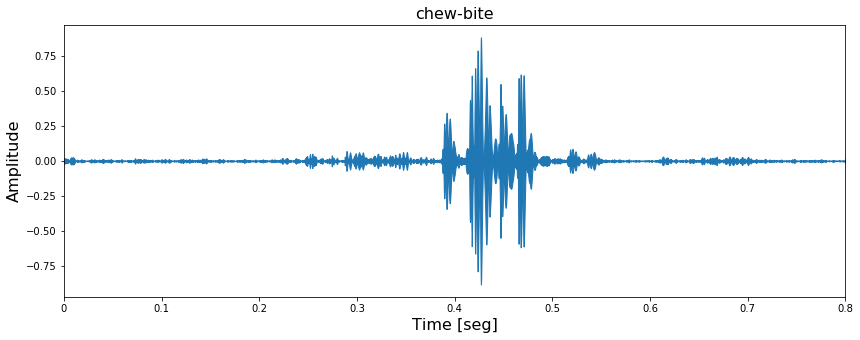

In [31]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)
plt.title('chew-bite',  fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xlabel('Time [seg]', fontsize=16)
pass

#### Fourier

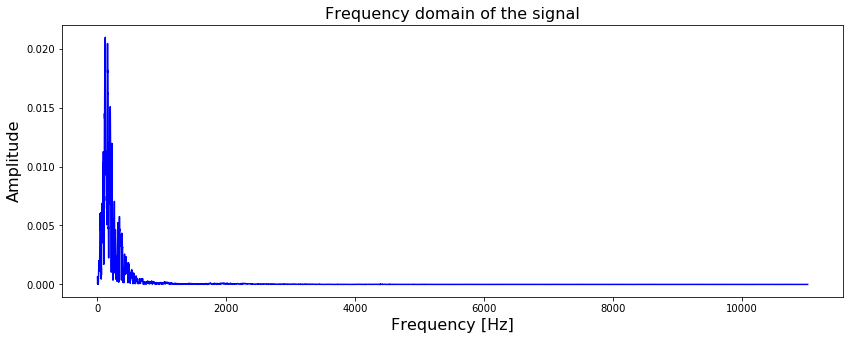

In [32]:
N = len(y)
T = 1/sr

f_values, fft_values = get_fft_values(y, T, N, sr)
plt.figure(figsize=(14, 5))

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

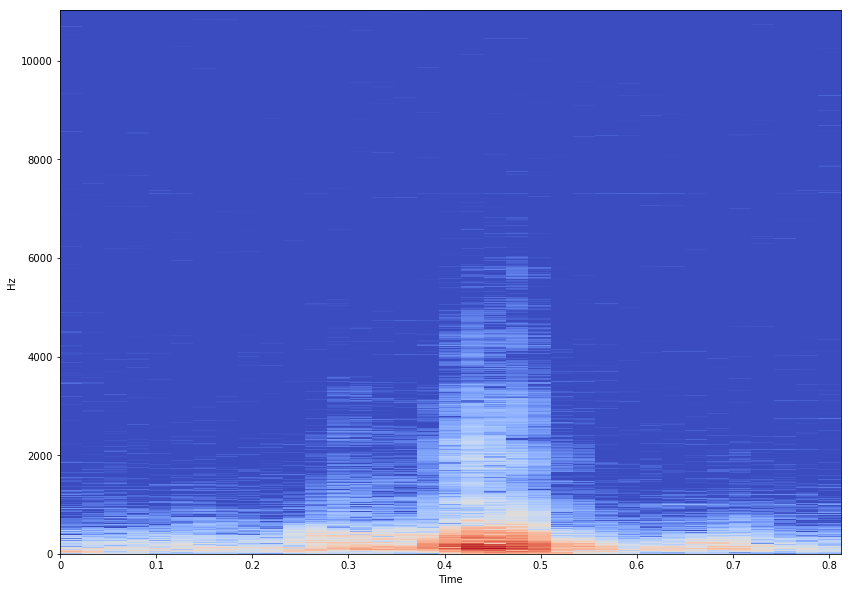

In [47]:
Y = librosa.stft(y)#,  n_fft=17640, win_length=1323,hop_length=882)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
pass

#### MFCC

In [34]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
# also N of FFT is defined with this value
hop_length = 512

In [35]:
# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, dct_type=2, n_mfcc=40)

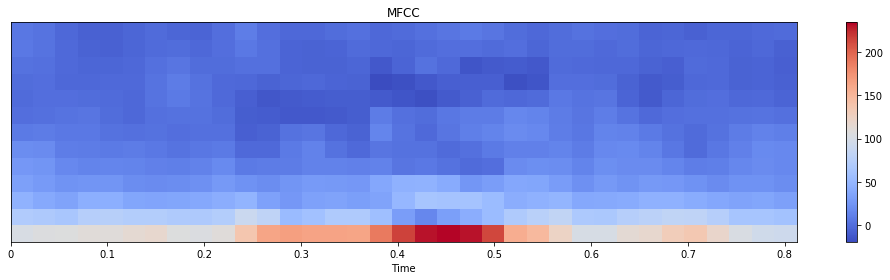

In [36]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(mfcc[1:14], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Wavelet

#### Discrete wavelet

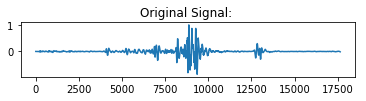

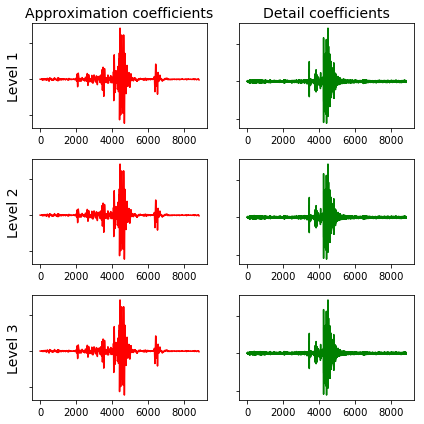

In [37]:
discrete_wavelet(y, waveletname='sym2', levels=3)

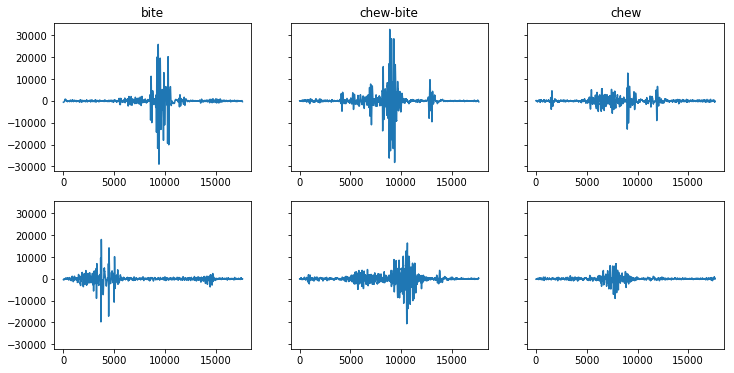

In [38]:
train_ds = WaveDataset("data/raw/", "data/train_labels.csv")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), sharey=True)

axes[0, 0].set_title("bite")
axes[0, 0].plot(train_ds[24][0])
axes[1, 0].plot(train_ds[48][0])

axes[0, 1].set_title("chew-bite")
axes[0, 1].plot(train_ds[0][0])
axes[1, 1].plot(train_ds[1][0])

axes[0, 2].set_title("chew")
axes[0, 2].plot(train_ds[2][0])
axes[1, 2].plot(train_ds[8][0]);

In [39]:
def preprocessing(raw_signal):

    # Rectification 
    rectified_signal = np.abs(raw_signal)

    # Low-pass filtering -> envelope
    sample_freq = 22050 # Hz
    cutoff_freq = 5     # Hz
    norm_cutoff_freq = cutoff_freq / (sample_freq / 2.0)
    b, a = signal.butter(2, norm_cutoff_freq, 'low')
    envelope = signal.filtfilt(b, a, rectified_signal, axis=0)

    return envelope, rectified_signal

In [40]:
def extract_features(raw_signal, plot_features=False):
    
    envelope, rectified_signal = preprocessing(raw_signal)
    
    threshold = 0.0115 * (2 ** 16) # to compute duration and envelope slope sign
    above_thres = envelope >= threshold  # samples to consider in computation
    
    max_pos = np.argmax(envelope)
    envelope_slope_sign = np.sign(np.diff(envelope, append=0)) * above_thres    
    duration_signal = np.ones(envelope.shape) * above_thres

    # features
    duration = np.sum(duration_signal)
    zero_crossing = np.count_nonzero(np.abs(np.diff(envelope_slope_sign)))
    amplitude = max(rectified_signal)
    ratio = np.trapz(envelope[:max_pos], axis=0) / np.trapz(envelope, axis=0)

    features = [duration, zero_crossing, float(amplitude), float(ratio)]  
    
    # Illustrate features
    if plot_features:
        print(features)
        fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8,6), sharex=True)
        axes[0].plot(raw_signal); axes[0].set_title("Señal sonora")
        axes[1].plot(envelope); axes[1].set_title("Envolvente")
        axes[2].plot(envelope_slope_sign); axes[2].set_title("Signo de la pendiente de la envolvente")
        axes[3].plot(duration_signal); axes[3].set_title("Duración")
        axes[3].set_xlabel("muestras")
        fig.tight_layout()
    
    return features

[4842.0, 3, 28961.0, 0.51973879464915]


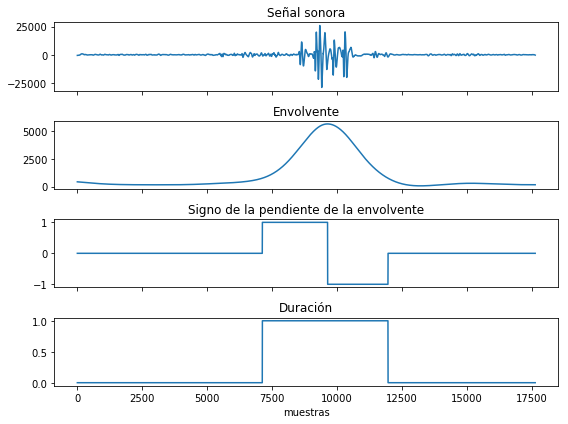

In [41]:
features = extract_features(train_ds[24][0], plot_features=True);